## Relax Inc. Take Home Challenge

The data includes a table of 12,000 users who signed up for the product in the last two years and a table of usage summary, with 207,917 rows for each day that a user logged in to the product, defined as engagement.

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven day  period ,  identify  which  factors  predict  future  user
adoption.

In [36]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [37]:
#load data from csv and preview dataset
users_df = pd.read_csv('takehome_users.csv', parse_dates=True)
engagement_df = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)

In [38]:
users_df.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0


In [39]:
engagement_df.head(10)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1


In [40]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [41]:
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


## Data Wrangling

In [42]:
# Convert 'creation_time' to datetime in users_df
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])

In [43]:
# Convert 'last_session_creation_time' from UNIX timestamp to datetime
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')

C:\Users\Quinn\anaconda3\Lib\site-packages\pandas\core\tools\datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


In [44]:
# Convert 'time_stamp' to datetime in engagement_df
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

In [45]:
# Check the conversion and display the first few rows again
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [46]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [47]:
# Group the engagement data by user and date (to count distinct days of logging in)
engagement_df['date'] = engagement_df['time_stamp'].dt.date
daily_engagement = engagement_df.groupby(['user_id', 'date']).count().reset_index()

In [48]:
# Find users who logged in on at least three separate days in any 7-day window
# Dictionary to track if a user is adopted
adopted_user = defaultdict(bool)

# Loop through each user
for user_id in daily_engagement['user_id'].unique():
    user_dates = daily_engagement[daily_engagement['user_id'] == user_id]['date'].sort_values()
    user_dates = pd.to_datetime(user_dates)
    if user_dates.diff().dt.days.cumsum().nunique() >= 3:
        adopted_user[user_id] = True

In [50]:
# Create a DataFrame to mark adopted users
adopted_df = pd.DataFrame.from_dict(adopted_user, orient='index', columns=['adopted'])
adopted_df.reset_index(inplace=True)
adopted_df.rename(columns={'index': 'user_id'}, inplace=True)

In [51]:
adopted_df.head()

,user_id,adopted
0,2,True
1,10,True
2,20,True
3,33,True
4,42,True


In [52]:
# Merge this info back with the users DataFrame
users_df = users_df.merge(adopted_df, left_on='object_id', right_on='user_id', how='left')

In [53]:
users_df['adopted'] = users_df['adopted'].fillna(False)

In [54]:
# Display the extended users DataFrame
users_df.head(25)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,NaN,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,NaN,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,NaN,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,NaN,False
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241.0,NaN,False
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN,NaN,False
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN,NaN,False
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN,NaN,False
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0,10.0,True


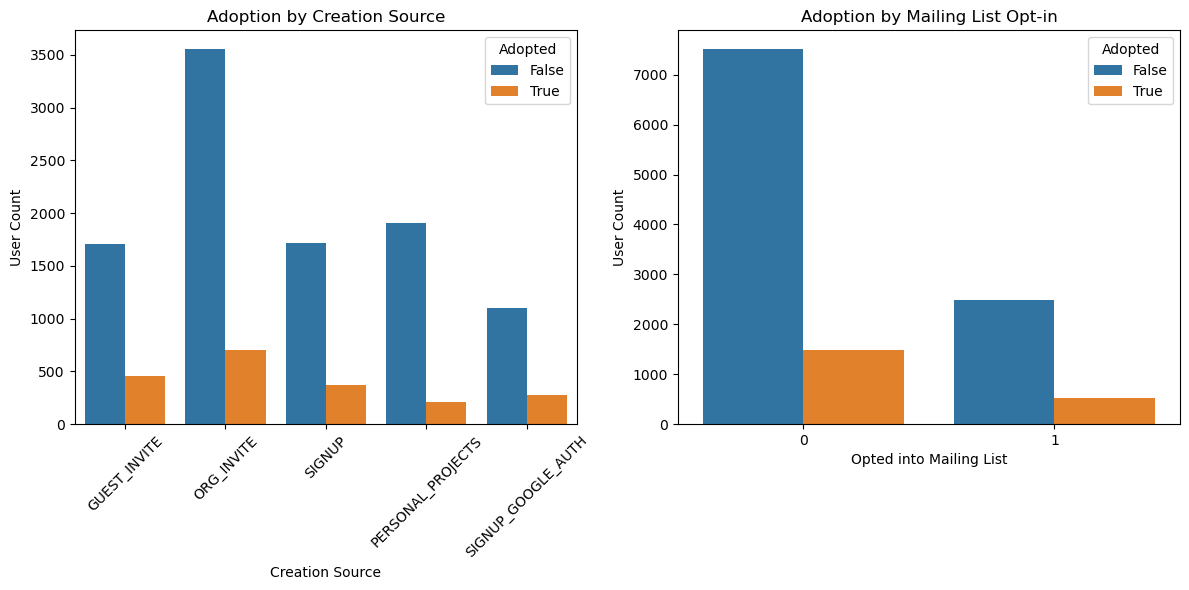

In [55]:
# Setting up the visualization
plt.figure(figsize=(12, 6))

# Creation Source vs Adopted
plt.subplot(1, 2, 1)
sns.countplot(data=users_df, x='creation_source', hue='adopted')
plt.title('Adoption by Creation Source')
plt.xticks(rotation=45)
plt.xlabel('Creation Source')
plt.ylabel('User Count')
plt.legend(title='Adopted')

# Mailing List vs Adopted
plt.subplot(1, 2, 2)
sns.countplot(data=users_df, x='opted_in_to_mailing_list', hue='adopted')
plt.title('Adoption by Mailing List Opt-in')
plt.xlabel('Opted into Mailing List')
plt.ylabel('User Count')
plt.legend(title='Adopted')

plt.tight_layout()
plt.show()

In [56]:
#cleaning up users_df to remove columns irrelevant to analysis
users_df = users_df.drop(columns=['email', 'name', 'invited_by_user_id', 'user_id'], axis=1)

In [57]:
users_df.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,False
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,True
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,False
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,False
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,False


In [58]:
# define new features to measure an accounts age and how long it has been used in days
users_df['account_age'] = (max(users_df['creation_time']) - users_df['creation_time']).dt.days
users_df['account_usage_time'] = (users_df['last_session_creation_time'] - users_df['creation_time']).dt.days

users_df.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,account_age,account_usage_time
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,False,38,0.0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,True,196,136.0
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,False,437,0.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,False,374,1.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,False,498,5.0


In [59]:
#cast bool adopted to int
users_df['adopted'] = users_df['adopted'].astype(int)
users_df.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,account_age,account_usage_time
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,0,38,0.0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,196,136.0
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,0,437,0.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,0,374,1.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,0,498,5.0


In [60]:
# encode creation_source into a categorical parameter
l = LabelEncoder()
users_df['creation_source'] = l.fit_transform(users_df['creation_source'])

In [61]:
#drop all rows with null values, i.e. users who haven't adopted and NaT's
users_df = users_df.dropna()

In [62]:
users_df.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,account_age,account_usage_time
0,1,2014-04-22 03:53:30,0,2014-04-22 03:53:30,1,0,11,0,38,0.0
1,2,2013-11-15 03:45:04,1,2014-03-31 03:45:04,0,0,1,1,196,136.0
2,3,2013-03-19 23:14:52,1,2013-03-19 23:14:52,0,0,94,0,437,0.0
3,4,2013-05-21 08:09:28,0,2013-05-22 08:09:28,0,0,1,0,374,1.0
4,5,2013-01-17 10:14:20,0,2013-01-22 10:14:20,0,0,193,0,498,5.0


In [63]:
users_df = users_df.reset_index(drop=True)

In [64]:
users_df.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,account_age,account_usage_time
0,1,2014-04-22 03:53:30,0,2014-04-22 03:53:30,1,0,11,0,38,0.0
1,2,2013-11-15 03:45:04,1,2014-03-31 03:45:04,0,0,1,1,196,136.0
2,3,2013-03-19 23:14:52,1,2013-03-19 23:14:52,0,0,94,0,437,0.0
3,4,2013-05-21 08:09:28,0,2013-05-22 08:09:28,0,0,1,0,374,1.0
4,5,2013-01-17 10:14:20,0,2013-01-22 10:14:20,0,0,193,0,498,5.0


Dataset is now ready for machine learning classification and feature importance analysis

# Modeling

Given the mix of numeric and categorical features and the importance of understanding feature impact, a good choice for this analysis is a decision tree-based model like Random Forest, which provides built-in methods for assessing feature importance.

In [65]:
X = users_df.drop(['creation_time','last_session_creation_time','adopted'], axis=1)
y = users_df['adopted']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

cls_rf = RandomForestClassifier(class_weight='balanced_subsample').fit(X_train, y_train)

In [67]:
y_pred = cls_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9664551223934723


96.6% accuracy is a pretty strong result, let's see what features influence that and check on other metrics

In [68]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1646   37]
 [  37  486]]


In [69]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1683
           1       0.93      0.93      0.93       523

    accuracy                           0.97      2206
   macro avg       0.95      0.95      0.95      2206
weighted avg       0.97      0.97      0.97      2206



In [72]:
#create features dataframe and fill with feature importances
features = pd.DataFrame()
features['val'] = cls_rf.feature_importances_
idx = users_df.drop(columns=['adopted','creation_time','last_session_creation_time'])
features = features.set_index(idx.columns)

features

,val
object_id,0.024961
creation_source,0.008399
opted_in_to_mailing_list,0.002280
enabled_for_marketing_drip,0.001572
org_id,0.028467
account_age,0.043680
account_usage_time,0.890641


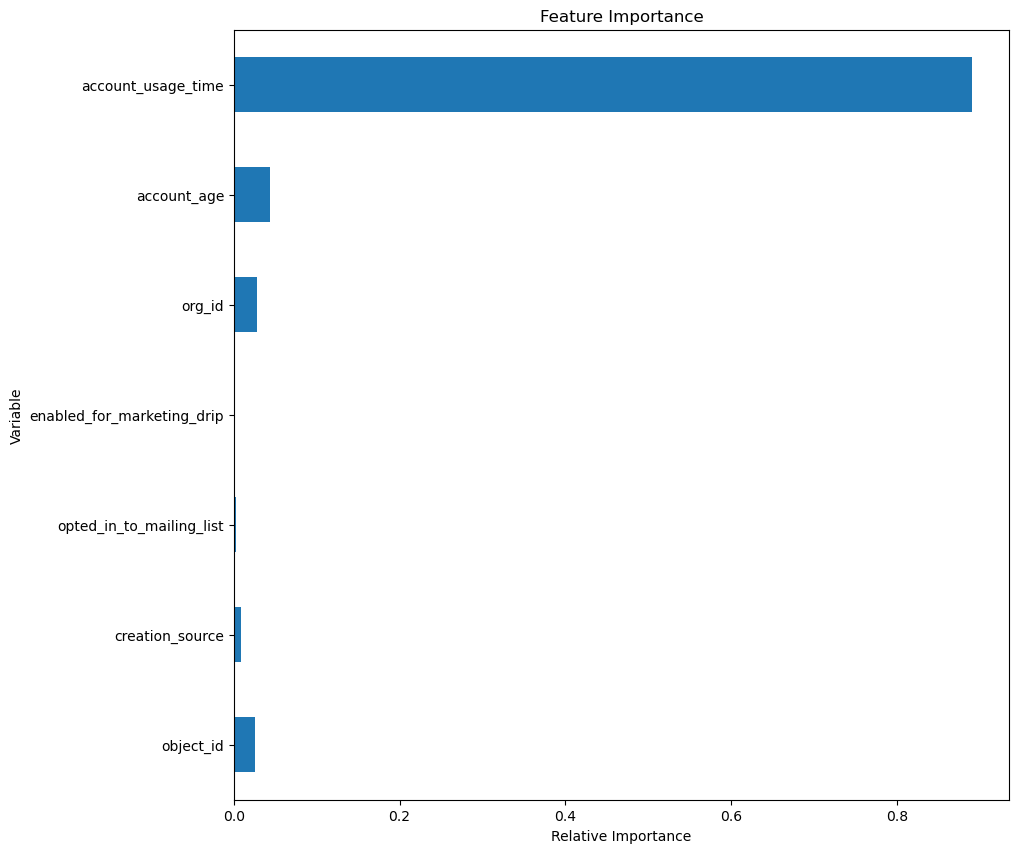

In [73]:
#visualize this result
plt.figure(figsize=(10,10))
(features['val']).plot(kind='barh', x=features.index)
plt.ylabel('Variable')
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

The above plot clearly indicates that account usage time is by far the most important feature for determining if a user has adopted the platform or not. This result is in line with what is expected, users that use the platform for the longest periods of time are also the most likely to be regular users. 